# Проект: классификация

In [435]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pandas import pivot_table
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing 
from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from  sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [436]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [437]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

### Задание 2

In [438]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [439]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
display(df['balance'].head())

def balance_clean(arg):
    """ Функция преобразовывает признак 'balance'

    Args:
        arg ([object]): balance с символами ',', '$', ' '
    
    Returns:
        arg ([float]): balance тип float
    """
    arg = str(arg)
    arg = arg.replace('$', '').replace(' ', '').replace(',', '.')
    return float(arg)

df['balance'] = df['balance'].apply(balance_clean)
print('Среднее значение по преобразованному стобцу "balance": ', round(df['balance'].mean(),3))
display(df['balance'].head())

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

Среднее значение по преобразованному стобцу "balance":  1529.129


0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64

### Задание 4

In [440]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее значение по преобразованному стобцу "balance": ', round(df['balance'].mean(),3))

Среднее значение по преобразованному стобцу "balance":  1526.936


### Задание 5

In [441]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

mask = (df['job'] == 'management') & (df['education'] == 'secondary')
print('Седний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: ', round(df[mask]['balance'].mean(), 3))

Седний баланс для клиентов с самой популярной работой и самым популярным уровнем образования:  1598.883


### Задание 6

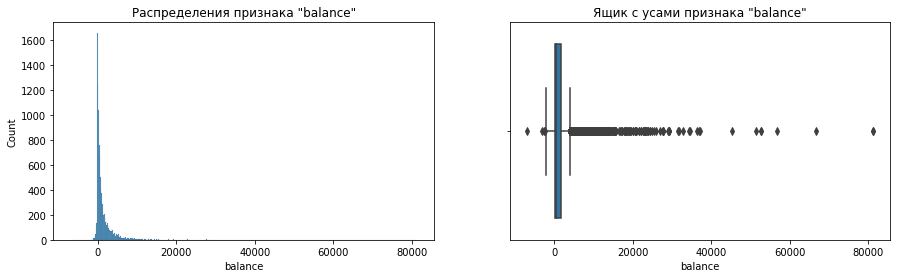

In [442]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Распределения признака "balance"');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Ящик с усами признака "balance"');

Типичный график признака, в котором присутствуют выбросы

In [443]:
# удалите все выбросы для признака balance
x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers = df[(x<lower_bound) | (x > upper_bound)]
cleaned = df[(x>lower_bound) & (x < upper_bound)]  # или включить границы МКР cleaned = df[(x>=lower_bound) & (x <= upper_bound)]

cleaned_df = df.drop(outliers.index, axis=0)

print('Верхняя и нижняя границы выбросов по методу Тьюки: ', lower_bound, ' и ', upper_bound)
print('Количество объектов после удаления выбросов: ', cleaned_df.shape[0])

Верхняя и нижняя границы выбросов по методу Тьюки:  -2241.0  и  4063.0
Количество объектов после удаления выбросов:  10105


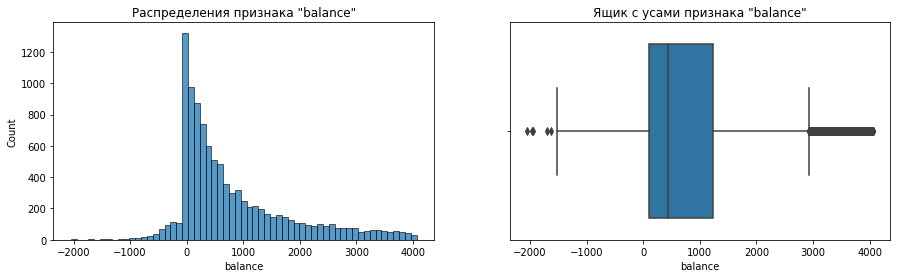

In [444]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_df, x='balance', ax=axes[0]);
histplot.set_title('Распределения признака "balance"');
boxplot = sns.boxplot(data=cleaned_df, x='balance', ax=axes[1]);
boxplot.set_title('Ящик с усами признака "balance"');

График признака, очищенного от выбросов

## Часть 2:  Разведывательный анализ

### Задание 1

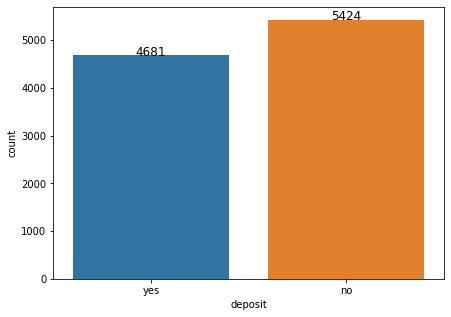

In [445]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig, ax = plt.subplots(figsize = (7,5))
ax = sns.countplot(data=cleaned_df, x='deposit')

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height()+1,rect.get_height(),horizontalalignment='center', fontsize = 12);

Данные в целом сбалансированы

### Задание 2

In [446]:
# посмотрим на основные результаты EDA в одну строчку кода
from pandas_profiling import ProfileReport
profile = ProfileReport(cleaned_df, title="Banking Pandas Profiling Report")
#profile

In [447]:
# рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


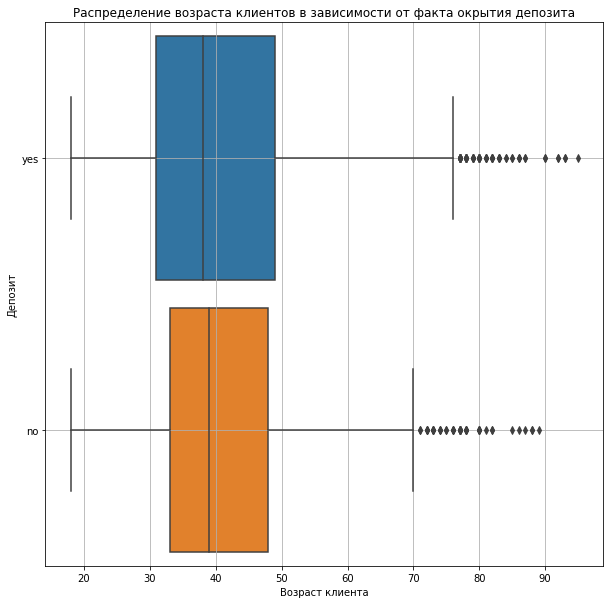

In [448]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='age',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение возраста клиентов в зависимости от факта окрытия депозита');
boxplot.set_xlabel('Возраст клиента');
boxplot.set_ylabel('Депозит');
boxplot.grid();

Межквартильный размах для клиентов, открывших депозит, больше, чем для тех, кто его не открыл. Также по графику можно определить потенциальные выбросы - возраст клиентов более 90.

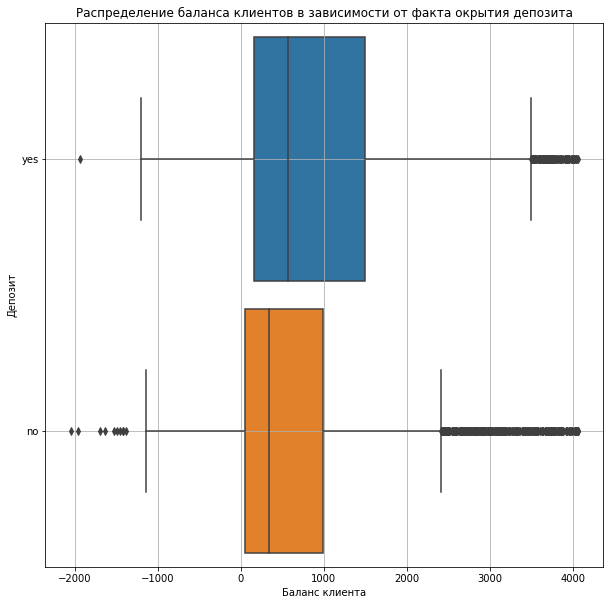

In [449]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение баланса клиентов в зависимости от факта окрытия депозита');
boxplot.set_xlabel('Баланс клиента');
boxplot.set_ylabel('Депозит');
boxplot.grid();

Медианный баланс и права граница распределения баланса у клиентов, открывших депозит, выше чем у неоткрывших.

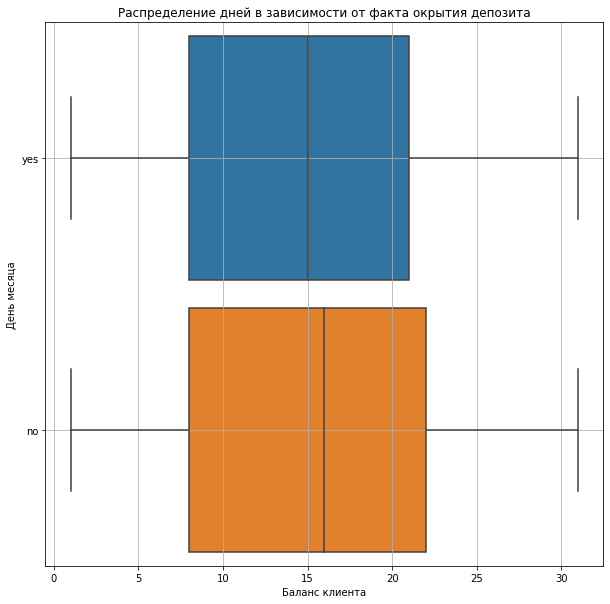

In [450]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='day',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение дней в зависимости от факта окрытия депозита');
boxplot.set_xlabel('Баланс клиента');
boxplot.set_ylabel('День месяца');
boxplot.grid();

Депозит чаще всего открывают примерно в 8-22 числах месяца.

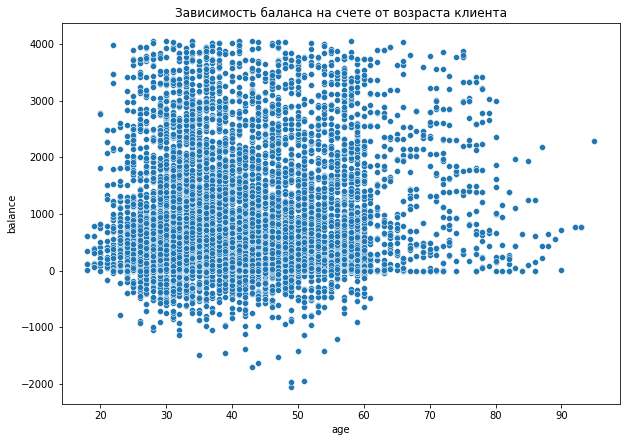

In [451]:
fig = plt.figure(figsize=(10, 7))
scatterplot = sns.scatterplot(
    data=cleaned_df,
    x='age',
    y='balance',
)
scatterplot.set_title('Зависимость баланса на счете от возраста клиента');

Свыше 60 лет практически не регистрируется отрицательный баланс. В возрасте 35-55 отрицательный баланс встречается чаще всего. После 25 чаще встречаются высокие значения баланса.

### Задание 3

In [452]:
# рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
cleaned_df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Наиболее часто встречающимся значением в типе занятости является management, в семейном положении - married, в уровне образования - secondary. Также чаще всего нет просроченного кредита, нет кредита на жилье и личные нужды и не известен результат прошлой маркетинговой кампании. Месяц последнего контакта с наивысшей частотой - май, а тип контакта - сотовая связь.

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


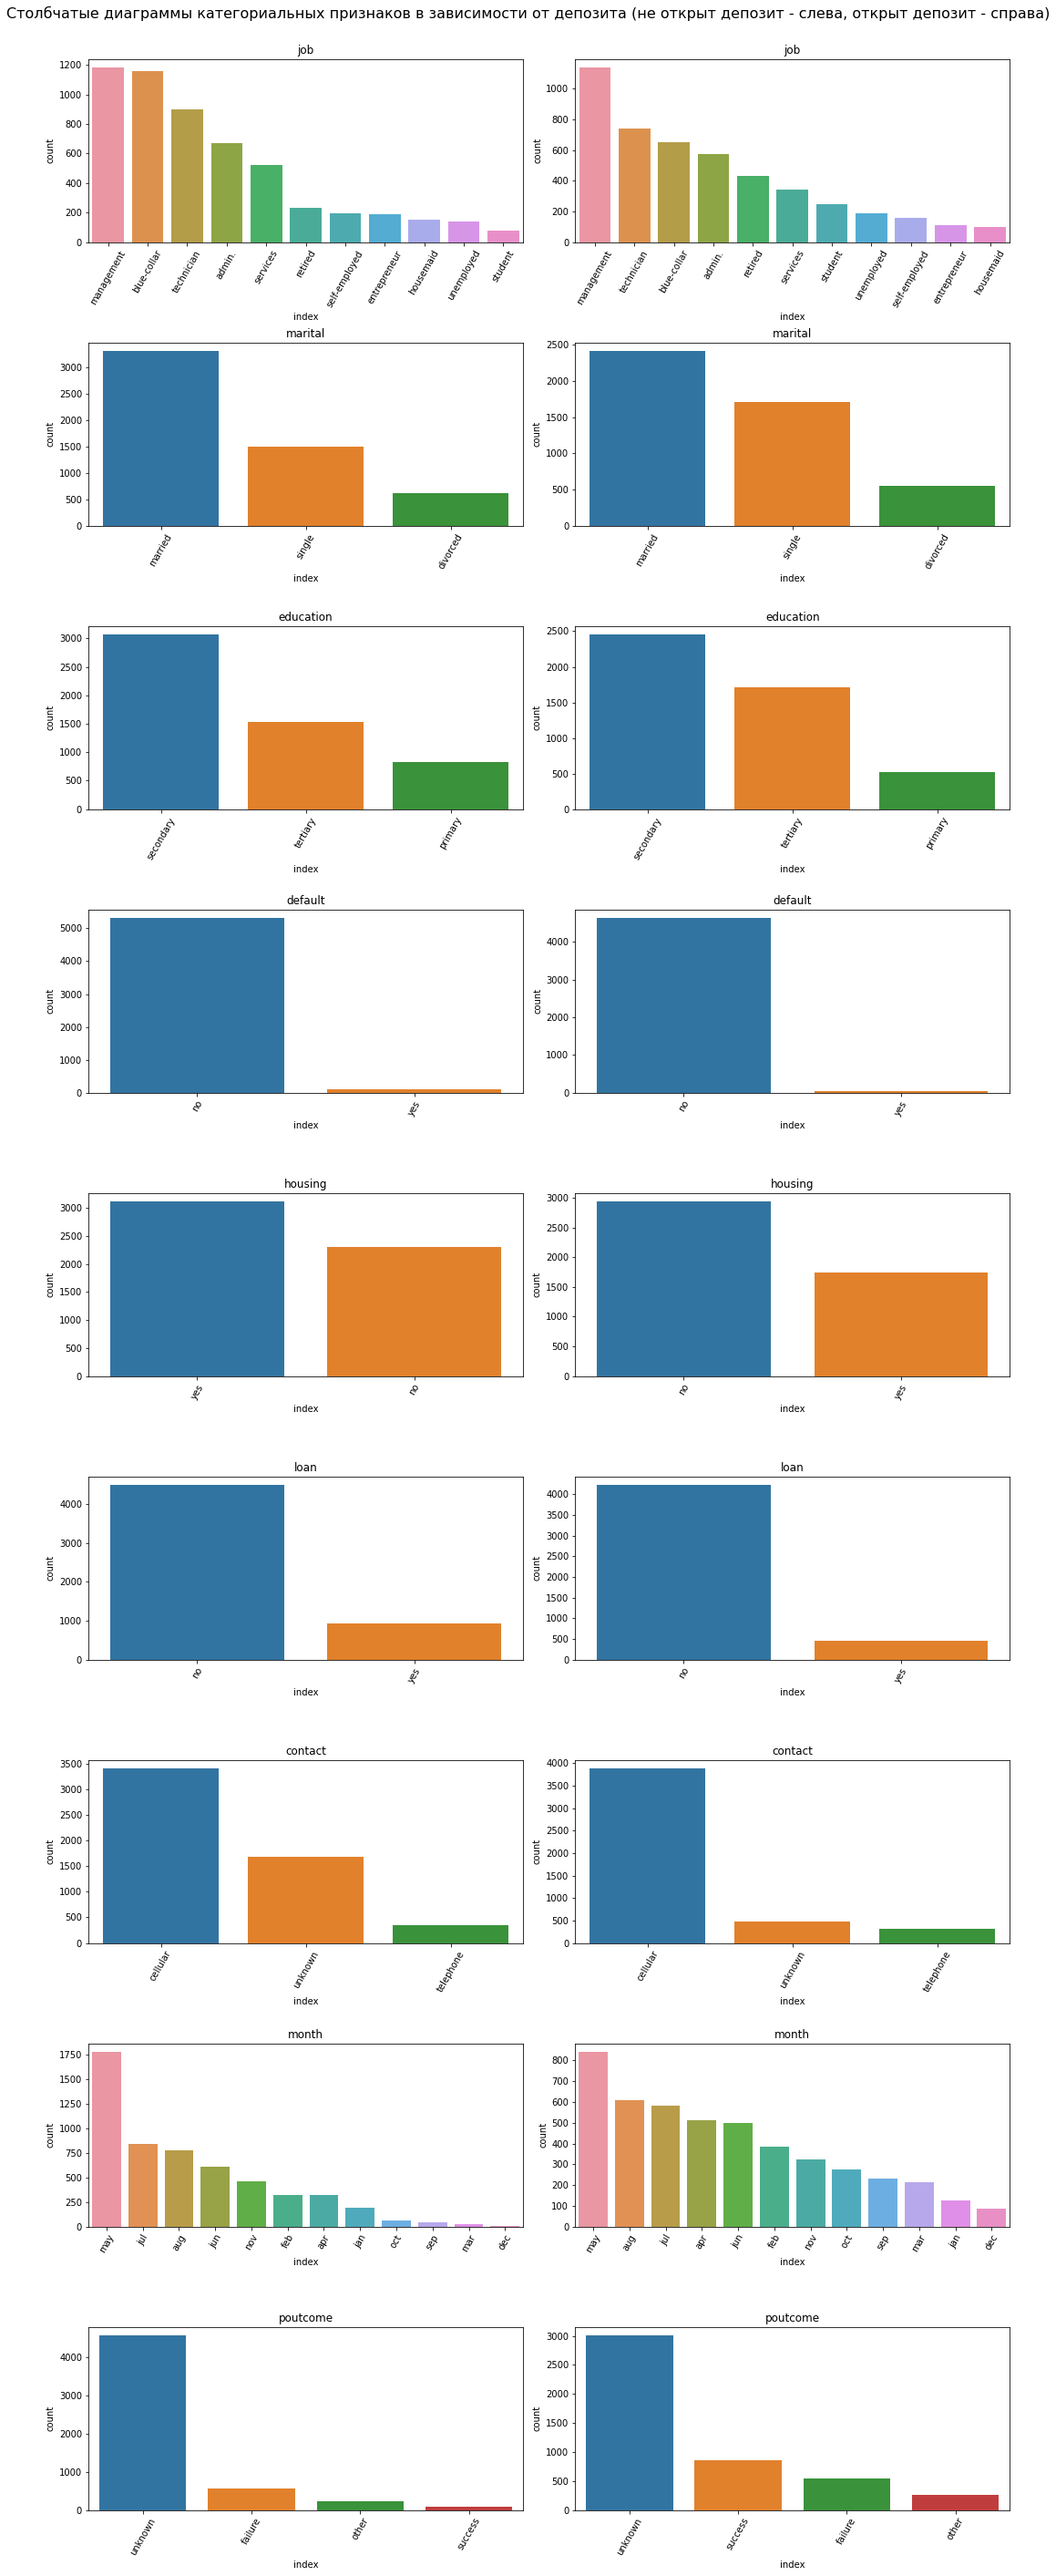

In [453]:
types = cleaned_df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features.remove('deposit')
print(cat_features)

n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize=(15, 40))

for index, item in enumerate(cat_features):
    count_data = (cleaned_df[cleaned_df['deposit'] == 'no'][item].value_counts()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='count', ax=axes[index][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(cat_features[index])
    
    deposit_yes_plot = (cleaned_df[cleaned_df['deposit'] == 'yes'][item].value_counts()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())
    count_barplot = sns.barplot(data=deposit_yes_plot, x='index', y='count', ax=axes[index][1])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(cat_features[index])

plt.tight_layout()

fig.suptitle('Столбчатые диаграммы категориальных признаков в зависимости от депозита (не открыт депозит - слева, открыт депозит - справа)', size=16)
fig.subplots_adjust(top=0.960)
plt.show()


### Задание 4

In [454]:
filtered_data = cleaned_df.groupby(['poutcome', 'deposit'], as_index=False)[['balance']].count()
filtered_data

,poutcome,deposit,balance
0,failure,no,562
1,failure,yes,547
2,other,no,216
3,other,yes,265
4,success,no,84
5,success,yes,861
6,unknown,no,4562
7,unknown,yes,3008


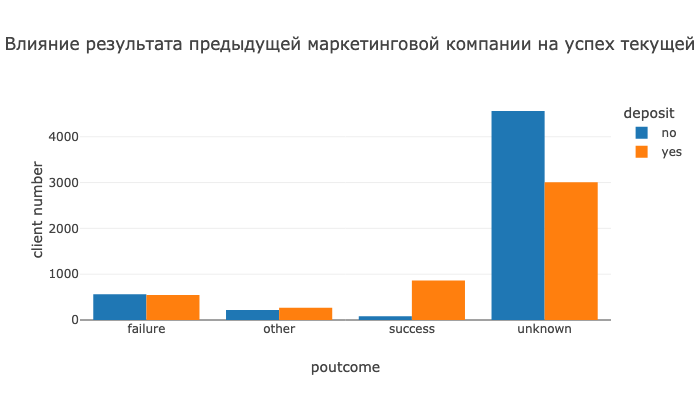

In [455]:
# узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
filtered_data = cleaned_df.groupby(['poutcome', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="poutcome",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Влияние результата предыдущей маркетинговой компании на успех текущей',
    width=700,
    height=400,
    template='none'
)

barchart.show('png')

Успех предыдущей маркетинговой кампании приводит к тому, что успех в текущей превалирует над количеством неудач.

### Задание 5

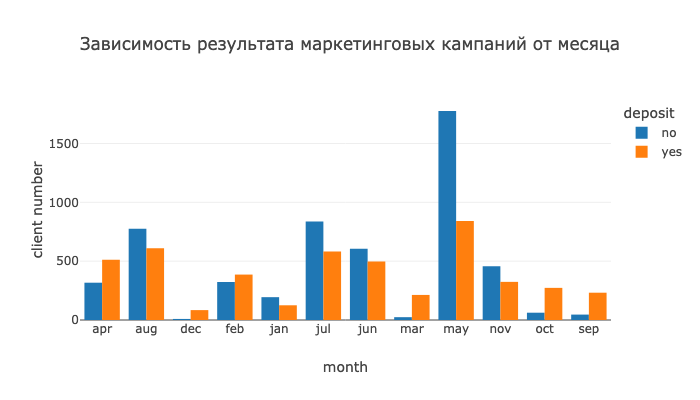

In [456]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
filtered_data = cleaned_df.groupby(['month', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="month",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость результата маркетинговых кампаний от месяца',
    width=700,
    height=400,
    template='none'
)

barchart.show('png')

Чаще всего клиенты банка отказывались открывать депозит в мае.

### Задание 6

In [457]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_group(age):
    """ Создание возрастных групп

    Args:
        age (int64): возраст

    Returns:
        (object): возрастная группа
    """
    if age <= 30:
        return '<30'
    elif 30 < age <= 40:
        return '30-40'
    elif 40 < age <= 50:
        return '40-50'
    elif 50 < age <= 60:
        return '50-60'
    else:
        return '60+'
    
    
cleaned_df['age group'] = cleaned_df['age'].apply(get_age_group)
cleaned_df[['age', 'age group']].head()

,age,age group
0,59,50-60
1,56,50-60
2,41,40-50
3,55,50-60
4,54,50-60


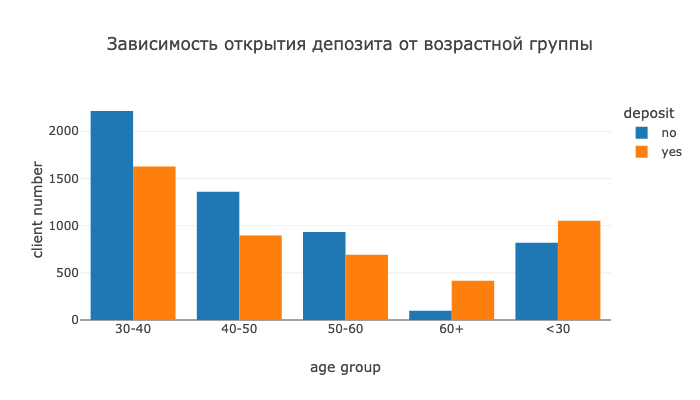

In [458]:
filtered_data = cleaned_df.groupby(['age group', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="age group",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от возрастной группы',
    width=700,
    height=400,
    template='none'
)

barchart.show('png')

Более склонны открывать депозит, чем отказываться от предложения, в возрастных группах 60+ и <30.

### Задание 7

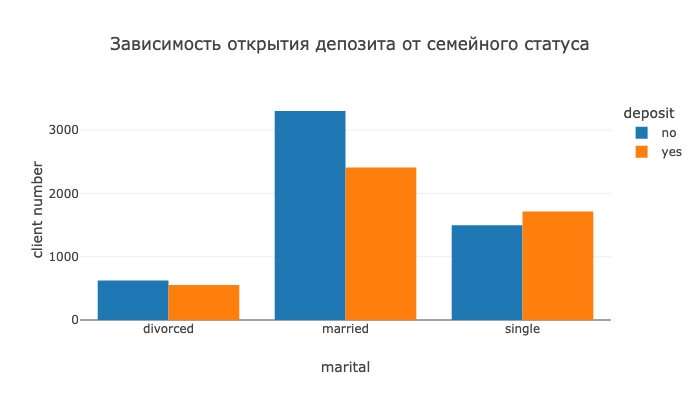

In [459]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
filtered_data = cleaned_df.groupby(['marital', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="marital",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от семейного статуса',
    width=700,
    height=400,
    template='none'
)

barchart.show('png')

Клиенты, находящиеся в браке, больше всех остальных из данного признака склонны открывать депозит. При этом одинокие клиенты чаще открывают депозит, чем отказываются от предложения

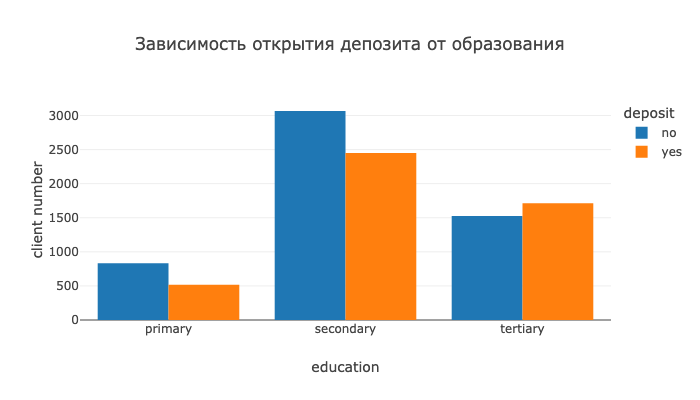

In [460]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
filtered_data = cleaned_df.groupby(['education', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="education",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от образования',
    width=700,
    height=400,
    template='none'
)

barchart.show('png')

Чаще всего открывают депозит клиенты со средним уровнем образования. Кроме того, клиенты с высшим уровнем образования чаще открывают депозит, чем отказываются от предложения банка

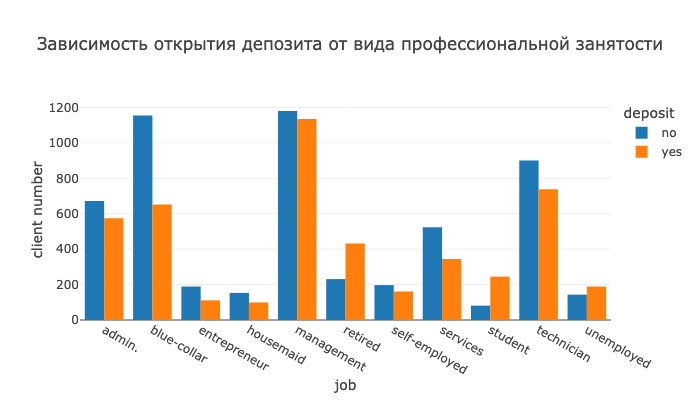

In [461]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
filtered_data = cleaned_df.groupby(['job', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="job",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от вида профессиональной занятости',
    width=700,
    height=400,
    template='none'
)

barchart.show('png')

Чаще всего открывают депозит клиенты с типом занятости: management, technician и blue-collar

### Задание 8

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


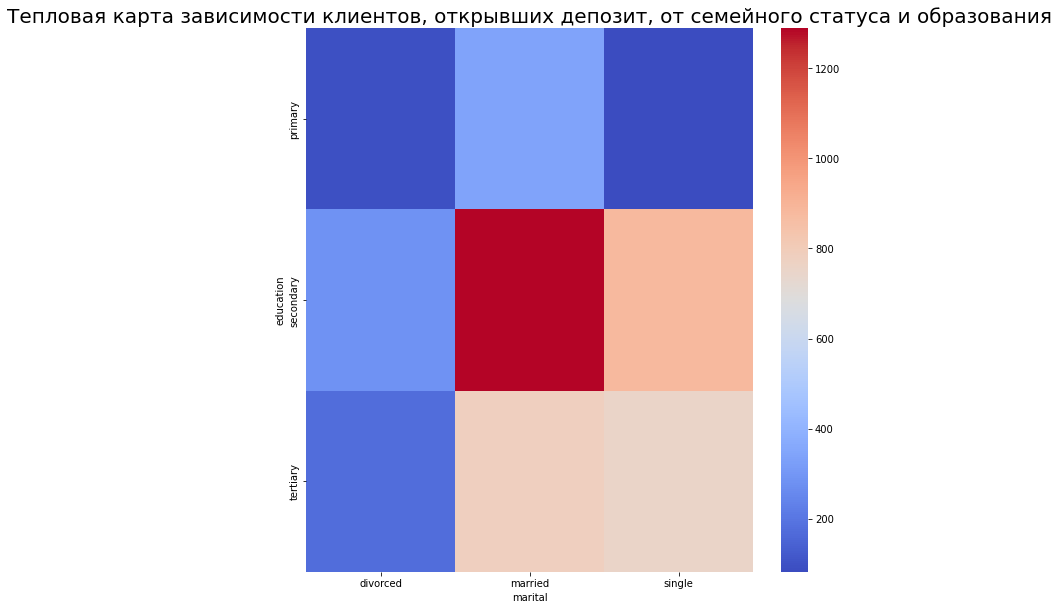

In [462]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
filtered_data = cleaned_df[cleaned_df['deposit'] == 'yes']

pivot_deposit_yes = filtered_data.pivot_table(
    values = 'deposit',
    columns = 'marital',
    index = 'education',
    aggfunc='count'
)
pivot_deposit_yes.columns = pivot_deposit_yes.columns.astype('string')
display(pivot_deposit_yes)

heatmap = sns.heatmap(data=pivot_deposit_yes, cmap='coolwarm')
heatmap.set_title('Тепловая карта зависимости клиентов, открывших депозит, от семейного статуса и образования', fontsize=20);

Чаще всего открывают депозит клиенты, находящиеся в браке или одинокие и имеющие средний уровень образования

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


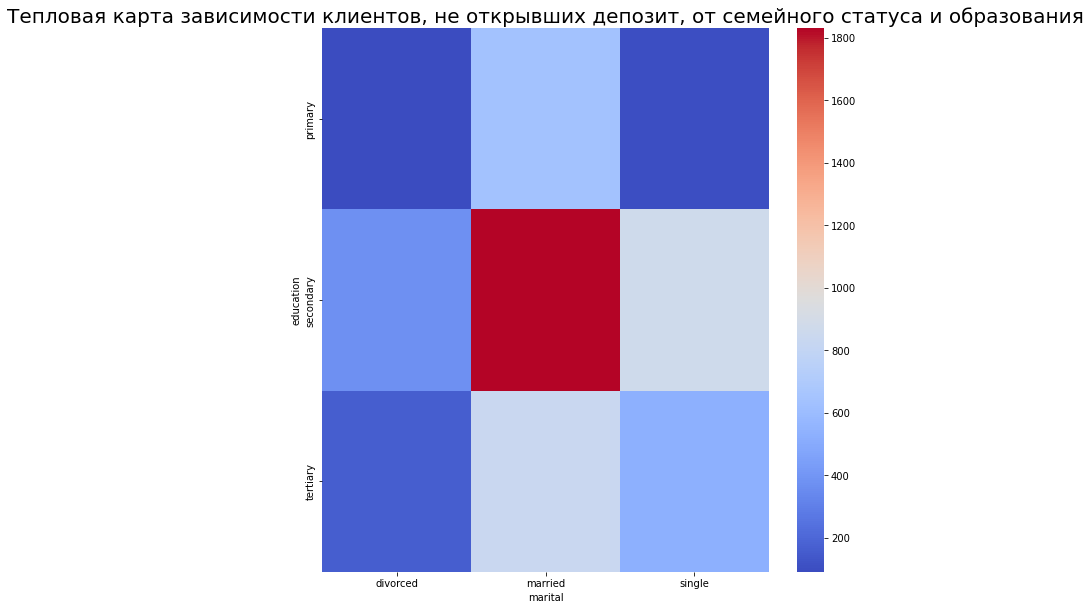

In [463]:
filtered_data = cleaned_df[cleaned_df['deposit'] == 'no']

pivot_deposit_no = filtered_data.pivot_table(
    values = 'deposit',
    columns = 'marital',
    index = 'education',
    aggfunc='count'
)
pivot_deposit_no.columns = pivot_deposit_no.columns.astype('string')
display(pivot_deposit_no)

heatmap = sns.heatmap(data=pivot_deposit_no, cmap='coolwarm')
heatmap.set_title('Тепловая карта зависимости клиентов, не открывших депозит, от семейного статуса и образования', fontsize=20);

Чаще всего открывают не депозит клиенты, находящиеся в браке или одинокие и имеющие средний уровень образования

## Часть 3: преобразование данных

### Задание 1

In [464]:
data = cleaned_df.copy()
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


In [465]:
# преобразуйте уровни образования
Label_Encoder = LabelEncoder()
cleaned_df['education'] = Label_Encoder.fit_transform(cleaned_df['education'])
print('Сумма получившихся значений для признака education', sum(cleaned_df['education']))

Сумма получившихся значений для признака education 11995


In [466]:
Label_Encoder = LabelEncoder()
cleaned_df['age group'] = Label_Encoder.fit_transform(cleaned_df['age group'])
cleaned_df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1


### Задание 2

In [467]:
# преобразуйте бинарные переменные в представление из нулей и единиц
data['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
data['default'] = data['default'].apply(lambda x: 1 if x == 'yes' else 0)
data['housing'] = data['housing'].apply(lambda x: 1 if x == 'yes' else 0)
data['loan'] = data['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [468]:
print('Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit равно', round(data['deposit'].std(), 3))

Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit равно 0.499


In [469]:
default_mean = data['default'].mean()
housing_mean = data['housing'].mean()
loan_mean = data['loan'].mean()

print('Сумма средних значений по трем бинарным признакам: ', round((default_mean + housing_mean + loan_mean), 3))

Сумма средних значений по трем бинарным признакам:  0.635


### Задание 3

In [470]:
# создайте дамми-переменные
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
encoded_data = pd.get_dummies(data[categorial_features])
data = pd.concat([data, encoded_data], axis = 1)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,secondary,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,secondary,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,secondary,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,secondary,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,tertiary,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


### Задание 4

<AxesSubplot:>

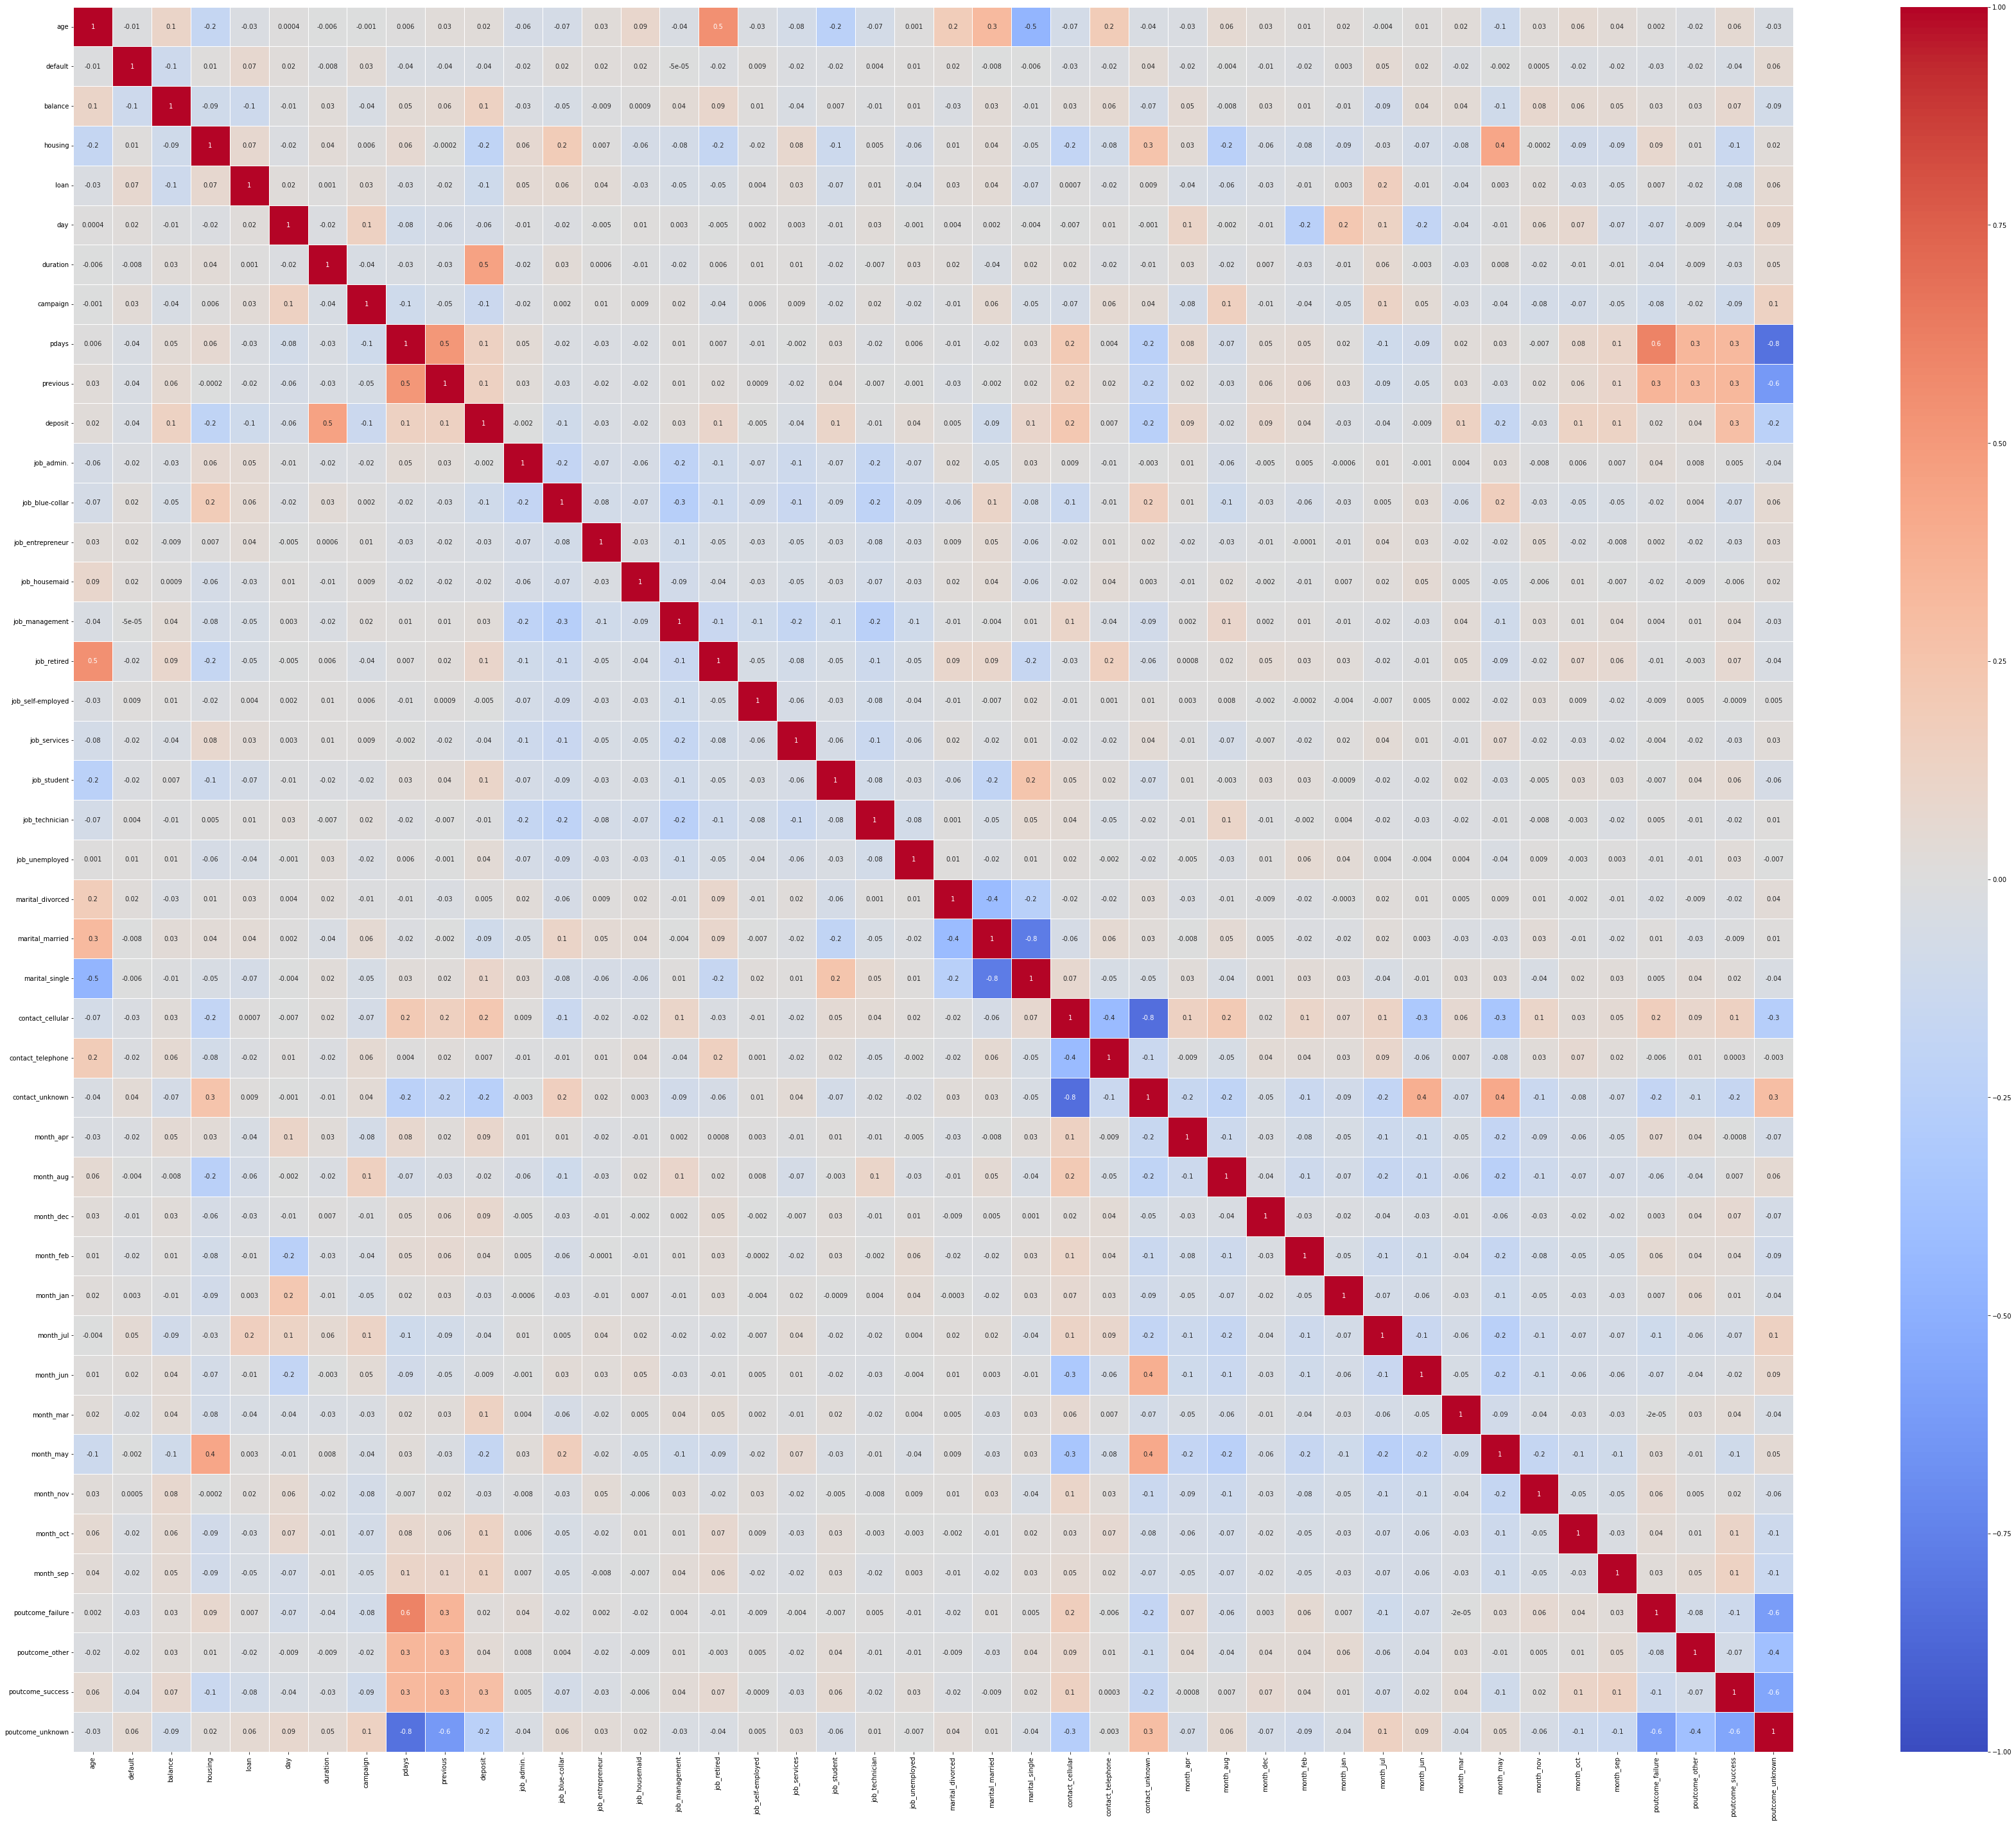

In [471]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (60,50))
sns.heatmap(data.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=.5)

### Задание 5

In [472]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [473]:
print('Размер тестовой выборки', X_test.shape)
print('Cреднее значение целевой переменной на тестовой выборке', round(y_test.mean(), 2))

Размер тестовой выборки (3335, 50)
Cреднее значение целевой переменной на тестовой выборке 0.46


### Задание 6

In [474]:
categorical_features = [col for col in X_train.columns.tolist() if X_train[col].dtype in ['object']]
print('Категориальные признаки', categorical_features)
data = data.drop(categorical_features, axis=1)
X_train = X_train.drop(categorical_features, axis=1)
X_test = X_test.drop(categorical_features, axis=1)

Категориальные признаки ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age group']


In [475]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out()
print('Топ-15 признаков ', selected_cols)

Топ-15 признаков  ['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 7

In [476]:
# нормализуйте данные с помощью minmaxsxaler
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

mm_scaler = preprocessing.MinMaxScaler()
scaled_X_train = mm_scaler.fit_transform(X_train)
scaled_X_test = mm_scaler.transform(X_test)
X_train = pd.DataFrame(scaled_X_train, columns=selected_cols)
X_test = pd.DataFrame(scaled_X_test, columns=selected_cols)

print('Среднее арифметическое для первого предиктора (т.е. для первого столбца матрицы) из тестовой выборки', round(X_test['balance'].mean(),2))

Среднее арифметическое для первого предиктора (т.е. для первого столбца матрицы) из тестовой выборки 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [477]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задание 2

In [478]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt.fit(X_train, y_train)
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 3

In [479]:
# подберите оптимальные параметры с помощью gridsearch
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)

print('Наилучшие значения параметров: {}'.format(grid_search.best_params_))
print('ccuracy на тестовом наборе: {:.2f}'.format(grid_search.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 10}
ccuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [480]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

In [481]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train, y_train)
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание3

In [482]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [('lr', lr), ('dt', dt), ('gb', gb)]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
)

stacking_model.fit(X_train, y_train)
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3634
           1       0.84      0.85      0.84      3136

    accuracy                           0.86      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.86      0.86      0.86      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1790
           1       0.81      0.80      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 4

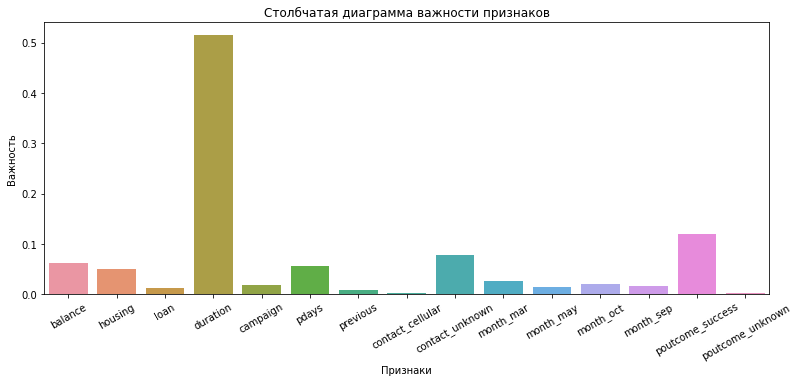

In [483]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(13, 5))
columns_name = X_train.columns
feature_importances = gb.feature_importances_
main_plot = sns.barplot(x=columns_name, y=feature_importances, ax=ax);
ax.set_title('Столбчатая диаграмма важности признаков')
ax.set_xlabel('Признаки')
ax.set_ylabel('Важность')
main_plot.xaxis.set_tick_params(rotation=30);

Наибольшей важностью обладают признаки: 'duration', 'poutcome_success', 'contact_unknown'

### Задание 5

In [484]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    
    return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2022-07-21 16:49:19,684] A new study created in memory with name: RandomForestClassifier
[I 2022-07-21 16:49:20,197] Trial 0 finished with value: 0.8406430466677073 and parameters: {'n_estimators': 183, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8406430466677073.
[I 2022-07-21 16:49:20,629] Trial 1 finished with value: 0.9012539184952978 and parameters: {'n_estimators': 125, 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9012539184952978.
[I 2022-07-21 16:49:21,166] Trial 2 finished with value: 0.8607950116913484 and parameters: {'n_estimators': 173, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9012539184952978.
[I 2022-07-21 16:49:21,654] Trial 3 finished with value: 0.8611369990680334 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9012539184952978.
[I 2022-07-21 16:49:22,072] Trial 4 finished with value: 0.8827906976744188 and parameters: {'n_

In [485]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 158, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [486]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3634
           1       0.91      0.93      0.92      3136

    accuracy                           0.92      6770
   macro avg       0.92      0.92      0.92      6770
weighted avg       0.92      0.92      0.92      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

